# **Part A: Probabilistic Gaussian Generative Classifier**
---

## **A1. Dataset and Setup**
- ### **Import Needed Functions**


In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


---
- ### **Load the full dataset (features X and labels y).**


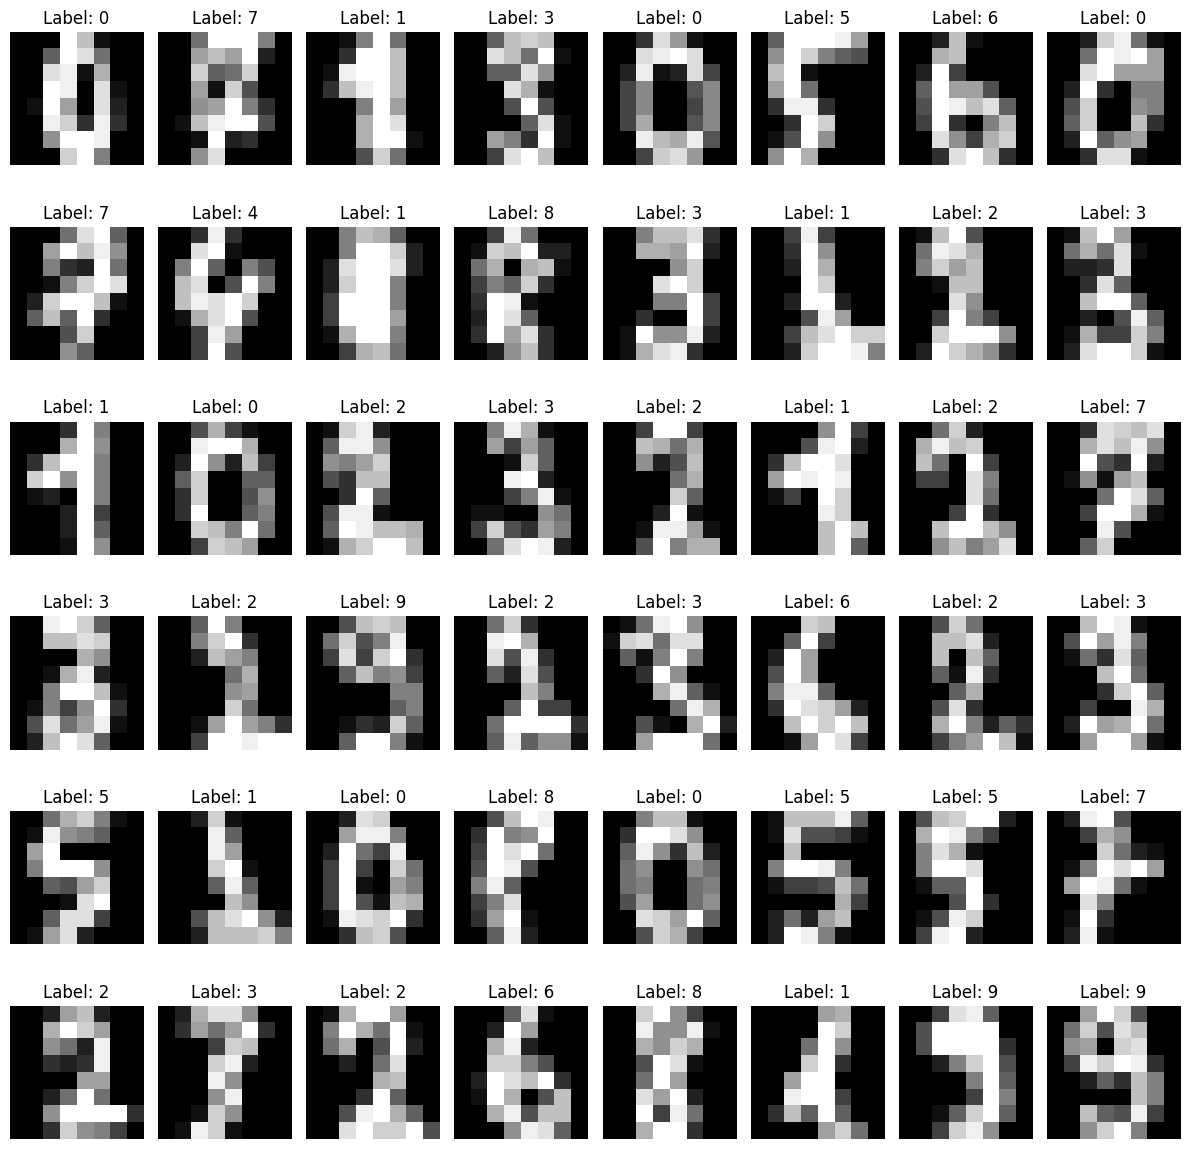

In [2]:
# Load the dataset
train_data = sklearn.datasets.load_digits()
X = train_data.data
y = train_data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, stratify=y_test, random_state=42)

# display all images with their labels from the training set
fig, axes = plt.subplots(6, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


- **standardize the features (for example, using StandardScaler from scikit-learn).**

In [3]:
# Data Preprocessing: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")

Data preprocessing completed!


---
---
## **A2. Gaussian Generative Model**
1. **Estimate the class priors π_k:**
2. **Estimate the class means μ_k**
3. **Estimate the shared covariance matrix Σ**
4. **Regularise the covariance**

In [4]:
# Estimate class prior probabilities π_k
def estimate_class_priors(y):
    classes, counts = np.unique(y, return_counts=True)
    priors = counts / len(y)
    return dict(zip(classes, priors))

# Estimate class means μ_k
def estimate_class_means(X, y):
    class_means = {}
    classes = np.unique(y)
    
    for cls in classes:
        class_data = X[y == cls]
        class_means[cls] = np.mean(class_data, axis=0)

    return class_means

# Estimate shared Covariance matrix Σ
def estimate_shared_covariance(X, y, class_means):
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    covariance = np.zeros((n_features, n_features))
    
    for cls in np.unique(y):
        class_data = X[y == cls]
        diff = class_data - class_means[cls]
        covariance += np.dot(diff.T, diff)
    
    covariance /= (n_samples - n_classes)
    return covariance

# Regularize Covariance matrix
def regularize_covariance(covariance, lambda_reg=1e-5):
    n, m = covariance.shape
    return covariance + lambda_reg * np.eye(n, m)

# Predict using Gaussian Discriminant Analysis
def predict_class_GDA(x,y, class_priors, class_means, covariance):
    classes = np.unique(y)
    probabilities = []
    inv_cov = np.linalg.inv(covariance)
    det_cov = np.linalg.det(covariance)
    
    for cls in classes:
        prior = class_priors[cls]
        mean = class_means[cls]
        diff = x - mean
        log_prob = (
            np.log(prior)
            - 0.5 * np.log(det_cov)
            - 0.5 * diff.T @ inv_cov @ diff
        )
        probabilities.append(log_prob)
    
    return classes[np.argmax(probabilities)]

### **Gaussian Discriminant Analysis (GDA)**

- **Class Priors (π_k):** estimated from `y_train`  
- **Class Means (μ_k):** computed per class  
- **Shared Covariance (Σ):** estimated and regularized  
- **Prediction:** first validation sample classified using GDA

In [5]:
# Estimate class prior probabilities π_k
π_k = estimate_class_priors(y_train)
print("Class Priors:", π_k)

# Estimate class means μ_k
μ_k = estimate_class_means(X_train_scaled, y_train)
print("Class Means calculated.", μ_k.keys())

# Estimate shared Covariance matrix Σ and regularize it
Σ = estimate_shared_covariance(X_train_scaled, y_train, μ_k)
Σ_reg = regularize_covariance(Σ)

# Predict the label of the first validation sample
print(f"predicted label of first validation sample: {predict_class_GDA(X_train_scaled[6],y_train, π_k, μ_k, Σ_reg)}")

Class Priors: {np.int64(0): np.float64(0.09864757358790771), np.int64(1): np.float64(0.10103420843277645), np.int64(2): np.float64(0.09864757358790771), np.int64(3): np.float64(0.10182975338106603), np.int64(4): np.float64(0.10103420843277645), np.int64(5): np.float64(0.10103420843277645), np.int64(6): np.float64(0.10103420843277645), np.int64(7): np.float64(0.09944311853619729), np.int64(8): np.float64(0.09705648369132856), np.int64(9): np.float64(0.10023866348448687)}
Class Means calculated. dict_keys([np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)])
predicted label of first validation sample: 6


---
---
## **A3. Hyperparameter Tuning and Evaluation**
1. **Choose a set of candidate values for λ**
2. **For each candidate value of λ:**
- Train the Gaussian generative classifier on the training set.
- Evaluate its accuracy on the validation set.
- Record the validation accuracy
3. **Select the value of λ that gives the best validation accuracy.**

Lambda: 0.0001, Validation Accuracy: 0.9592592592592593
Lambda: 0.001, Validation Accuracy: 0.9592592592592593
Lambda: 0.01, Validation Accuracy: 0.9629629629629629
Lambda: 0.1, Validation Accuracy: 0.9629629629629629
Lambda: 1, Validation Accuracy: 0.9481481481481482
Lambda: 10, Validation Accuracy: 0.9
Best lambda: 0.01 with validation accuracy: 0.9629629629629629


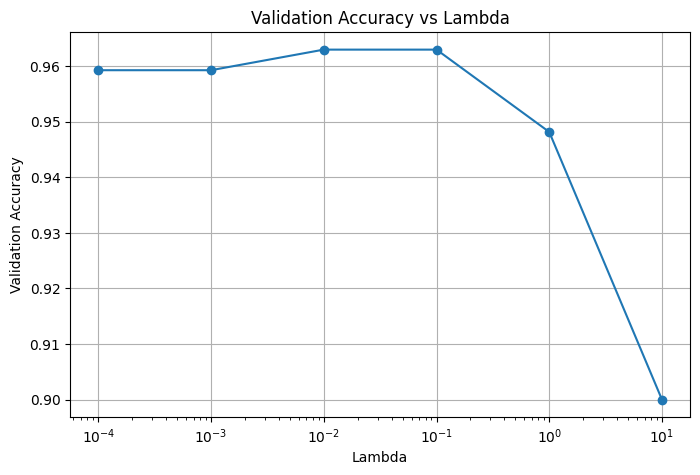

In [6]:
# Hyperparameter Tuning for Lambda in Covariance Regularization
lambda_reg = [ 1e-4, 1e-3, 1e-2, 1e-1 , 1, 10 ]
best_lambda = None
best_accuracy = 0
accuracies = []

for lam in lambda_reg:
    Σ_reg = regularize_covariance(Σ, lambda_reg=lam)
    
    # Predict on validation set
    y_val_pred = [predict_class_GDA(x, y_train, π_k, μ_k, Σ_reg) for x in X_val_scaled]
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracies.append(accuracy)
    print(f"Lambda: {lam}, Validation Accuracy: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda = lam 
    
print(f"Best lambda: {best_lambda} with validation accuracy: {best_accuracy}")

# display accuracy vs lambda plot
plt.figure(figsize=(8, 5))
plt.plot(lambda_reg, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Lambda')
plt.grid(True)
plt.show()

---
### **Final model:**
- Combine the training and validation sets into a single training set.
- Retrain  Gaussian generative classifier on this combined set using the chosen 
λ (*Best lambda: 0.01*).
- Evaluate this final model on the test set only once.


In [7]:
# Final Model Training and Evaluation
X_train_combined = np.vstack((X_train_scaled, X_val_scaled))
y_train_combined = np.hstack((y_train, y_val))

# Re-estimate parameters with the best lambda
π_k = estimate_class_priors(y_train_combined)
print("Class Priors:", π_k)

# Estimate class means
μ_k = estimate_class_means(X_train_combined, y_train_combined)
print("Class Means calculated.")

# Estimate shared Covariance matrix Σ and regularize it
Σ = estimate_shared_covariance(X_train_combined, y_train_combined, μ_k)
Σ_reg = regularize_covariance(Σ, lambda_reg=best_lambda)

# Predict on test set 
y_test_pred = [predict_class_GDA(x, y_test, π_k, μ_k, Σ_reg) for x in X_test_scaled]



Class Priors: {np.int64(0): np.float64(0.09888670595939751), np.int64(1): np.float64(0.10150622134905042), np.int64(2): np.float64(0.09823182711198428), np.int64(3): np.float64(0.10216110019646366), np.int64(4): np.float64(0.1008513425016372), np.int64(5): np.float64(0.1008513425016372), np.int64(6): np.float64(0.1008513425016372), np.int64(7): np.float64(0.09954158480681075), np.int64(8): np.float64(0.09692206941715782), np.int64(9): np.float64(0.10019646365422397)}
Class Means calculated.


---
### **Final Report:**
- *Test accuracy*
- *Macro-averaged precision*
- *Macro-averaged recall*
- *Macro-averaged F1-score*
- *The confusion matrix over the 10 digit classes*

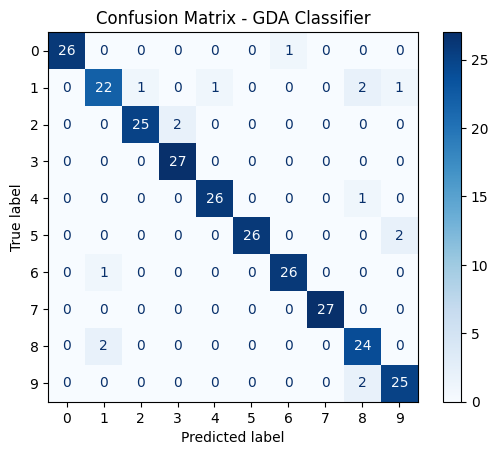

Classification Report:
Test Accuracy: 0.9407407407407408
Test Macro Precision: 0.9418942219976701
Test Macro Recall: 0.9407203907203907
Test Macro F1 Score: 0.9405674933033422


In [ ]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_test_pred)
class_names_lr = [str(i) for i in range(10)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_lr)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - GDA Classifier')
plt.show()
     
print("Classification Report:")
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='macro')
recall = recall_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f"Test Accuracy: {accuracy}")
print(f"Test Macro Precision: {precision}")
print(f"Test Macro Recall: {recall}")
print(f"Test Macro F1 Score: {f1}")

---
---


 
  
  
## **A4. Discussion and Analysis**

### **Confusion Between Digits**
Examining the confusion matrix reveals which digit pairs are most frequently misclassified. Digits with similar shapes tend to be confused more often—for example, 4 and 9 may be confused due to overlapping features, as might 3 and 8, or 0 and 6. The confusion matrix provides clear insight into the model's failure modes, showing that certain digits consistently receive more misclassifications than others. These patterns reflect the inherent visual similarity between some digit pairs and indicate where the Gaussian generative model struggles to distinguish classes in the feature space.

### **Impact of Regularization Parameter λ and Model Strengths/Weaknesses**
The hyperparameter tuning process revealed that the choice of λ significantly affected validation accuracy, with certain values (such as 0.01) outperforming others considerably. Regularization prevents the covariance matrix from becoming ill-conditioned, and too little regularization (very small λ) can lead to numerical instability, while too much (very large λ) over-smooths the covariance estimate. The Gaussian Discriminant Analysis model demonstrates several strengths on this dataset: it is computationally efficient, provides probabilistic predictions, and requires relatively few parameters to estimate. However, it also has notable weaknesses—the assumption of class-conditional Gaussian distributions may not hold perfectly for handwritten digits, and the shared covariance assumption across all classes can be overly restrictive. Additionally, the model may struggle with multimodal class distributions (where a single digit class might have multiple visual variations), limiting its ability to capture the true complexity of real-world digit variations.

---
---
